In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

# Target Orbit Env

### Problem: 
What is the policy that allows you to stay above the surface of the circular 2-D planet for as long as possible as near as possible to the target altitude with expending the least amount of energy (making actions).

### The Math:
For the 2D circular problem, we're solving a physics problem described by the Lagrangian,

$\mathcal{L} = \frac{1}{2}(\dot{r}^2+r^2 \dot{\theta}^2) + \frac{GM}{r}$ 

To make the problem accessable via computation, we choose a natural set of units such that,

$GM = 1 \ ln^3/tn^2$, $R_{\rm planet} = 1 \ ln$

where $ln$ is a "natural length" and $tn$ is a "natural time" for the problem. The solution to the Lagrangian minimization problem gives the differential equation sets below.

$\frac{d}{dt}\left(\frac{d \mathcal{L}}{d\dot{r}}\right) = \frac{d \mathcal{L}}{dr} \rightarrow \ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\frac{d}{dt}\left(\frac{d \mathcal{L}}{d\dot{\theta}}\right) = \frac{d \mathcal{L}}{d\theta} \rightarrow \frac{d}{dt}\left(r^2 \dot{\theta} \right) = 0 \rightarrow  \ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### Example Unit Converstion:
Let's look at an example to understand the natural units of the problem, ie we'll use the radius of the Earth as the natural length, and the mass of the Earth as our planet mass.

$1 \ ln = 6 \times 10^6 \ m$

$GM = \left(6.67 \times 10^{-11} \ \frac{m^3}{kg \ s^2} \right) * \left(6 \times 10^{24} \ kg \right) = \left(4 \times 10^{14} \ \frac{m^3}{s^2} \right)* \left(1 \ \frac{ln}{6 \times 10^6 \ m} \right)^3 \left(X \ \frac{s}{tn} \right)^2 = 1 \ \frac{ln^3}{tn^2}$

$\left(1.85 \times 10^{-6} \right) \ X^2 = 1 \rightarrow X = 734.66$

$1 \ s = 0.0013 \ tn$


### Reward Conditions:
What is the reward function for this problem?

One we want to reward the agent for each step of staying above the surface, and end the episode upon contact with the surface.

$r(s,a) = FR$ if $r > 1.0 \ ln$, where $FR > 0$ is the flight reward.

We want the agent to get as close to the target altitute as possible so a penality function is appropriate when the agent isn't at the target altitute.

$r(s,a) = -\lambda_t ||r - R_t||_n$

where $\lambda_t > 0$ is the importance of how rapidly the agent should get to the altitude, as well we have $n$ which we dont know if the L2 or L1 norm is best for this problem.

We also need to penalize the agent for making any actions at all, ie rotating the vehicle orientation or firing the main engine.  It doesn't make much sense for the same energy expenditure for firing the main engine vs changing the agent's oreientation, so we will have main engine penality $ME$ and orientation penality $OP$, such that our final reward function looks like.


$r(s,a) = FR -\lambda_t ||r - R_t||_n - ME(a) - OP(a)$

### Giving our Agent a Hint:
It could take a very long time for the agent to randomly find the optimal trajectory so we can do two things to help our agent find what we're looking for more rapidly. 

1) We can pretrain our agent with a simple policy that has the agent rotating more tangentially to the surface of the planet as it asscends.

2) We can add another penality term to the reward that penalizes the agent not having an the correct orbital angular velocity for the selected target altitude.


Circular orbital velocity in natural units:

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2} = 0$

$\dot{\theta} = R_t^{-3/2}$

And how long is a circular orbtial period in natural units?

$T = \frac{2\pi}{\dot{\theta}} = 2\pi R_t^{3/2}$

We can use this time to stop the episode if the time running is exceedingly longer than this measure.

### Example:
If the target altitude is $R_t = 2 \ ln$ then how long is the orbital period?

$T = 17.8 \ tn = 3.6 \ hrs$

If we use time steps of $dt = 1 \ s$ then the orbital period will be completed in,

$T/dt = 17.8 \ tn / (1 tn/736.66 s) / (1s/step) =  13,113$ steps

This gives you an idea of how to limit the simulation epsiodes. On one hand we want high frequency policy control updates, on the other we want our episodes to be as few steps as possible, this leads to the other possible way of constraining the episode length in terms of max steps ($MS$) can imply the time step in the simulation.

$MS = 100 \rightarrow 100 = 13113/(x \ s/ step) \rightarrow 1 \ step = 131.13 \ s$

The general expression is

$MS =2 \pi R_t^{3/2}/(1 \ tn/X \ s) / ( x \ s/step)$

Where $X = (R_t^3/GM)^{1/2}$ in SI units, and $R_t$ below is in natural units.

$ (2 \pi R_t^{3/2})*X/MS \ s = 1 \ step$

In [2]:
X = ((6*10**6)**3/(6.674*10**(-11)*6*10**(24)))**0.5
MS = 5000
print('seconds per step: ', (2*np.pi*2**1.5)*X/MS)

seconds per step:  2.6104357394519746


## Solving the System of Equations

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

$y_2 = \theta$

$y_3 = \dot{\theta}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 = y_0 y_3^2 - \frac{1}{y_0^2}$

$\dot{y}_2 = y_3$

$\dot{y}_3 = -2 \frac{y_1}{y_0} y_3$ 

### RK4 Algorithm


In [2]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, ln_m = 1000.0, dt_s = 1.0, target_r = 2.0, thrust_gs= 1.25, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 100.0]), 
                                           high=np.array([100.0, 100.0]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0., -10., 0.0, -10.0]), 
                                                high=np.array([10., 10., 2*np.pi, 10.0]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        planet_Mass_kg = 5.972*10**(24)
        planet_R_km = 6371.0
        planet_R_m = planet_R_km*10**3
        self.planet_R_ln = planet_R_m/ln_m
        
        # Convert to Natural Problem Units
        # tn_s = (R^2/GM*X m)^1/2 -- where all measures are in SI units
        
        tn_s = (planet_R_m**2/(G*planet_Mass_kg)*ln_m)**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = ln_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1/ln_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_r = self.planet_R_ln + target_r
        self.max_r = self.planet_R_ln + 1.5*self.target_r
        
        # solving the oribital angular velocity in natural units
        self.orbit_theta_dot = self.planet_R_ln*self.target_r**(-1.5)
        self.max_theta_dot = 10.0*self.orbit_theta_dot
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi/self.orbit_theta_dot
        # adding in a buffer to allow it to go a little longer
        self.max_time = 5*self.max_time
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.orbit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
            
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g = (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        
        self.angle_step = 1.0*np.pi/180.0
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.0
        
        # Translational Coordinates
        self.r = self.planet_R_ln
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), 
                                         self.orientation_angle]])
        
        obs = np.array([self.r, self.r_dot, self.theta, self.theta_dot])
        
        return obs
    
    # discrete actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        action_mag = 0.0
        
        # Rotate Right
        if action == 0:
            self.orientation_angle -= self.angle_step
            #action_penalty = -self.orientation_penalty
        # Rotate Left
        elif action == 1:
            self.orientation_angle += self.angle_step
            #action_penalty = -self.orientation_penalty
        # Thrust
        elif action == 2:
            action_mag = self.max_thrust
            #action_penalty = -self.thrust_penalty
        # 1% thrust
        elif action == 3:
            action_mag = 0.01*self.max_thrust
        # Coast
        else:
            action_mag = 0.0
            action_penalty = 0.0
        
        # Translating the actions into the planet centric coordinate system
        action_vector = action_mag*np.array([np.cos(self.orientation_angle), 
                                             np.sin(self.orientation_angle)])
        
        # Apply the orientation action prior to the state propagator
        #self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        #self.orientation_rate += orientation_thrust*self.dt

        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        rd_k1 = self.r_dot
        rdd_k1 = self.r*self.theta_dot**2 - self.planet_R_ln**2/self.r**2 + action_along_r
        thetad_k1 = self.theta_dot
        thetadd_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        rd_k2 = (self.r_dot + rdd_k1*self.dt/2)
        rdd_k2 = (self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k1*self.dt/2)**2 + action_along_r
        thetad_k2 = (self.theta_dot + thetadd_k1*self.dt/2)
        thetadd_k2 = -2.0*(self.r_dot + rdd_k1*self.dt/2)/(self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2) + action_along_theta
        
        rd_k3 = (self.r_dot + rdd_k2*self.dt/2)
        rdd_k3 = (self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k2*self.dt/2)**2 + action_along_r
        thetad_k3 = (self.theta_dot + thetadd_k2*self.dt/2)
        thetadd_k3 = -2.0*(self.r_dot + rdd_k2*self.dt/2)/(self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2) + action_along_theta
        
        rd_k4 = (self.r_dot + rdd_k3*self.dt)
        rdd_k4 = (self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt)**2 - self.planet_R_ln**2/(self.r + rd_k3*self.dt)**2 + action_along_r
        thetad_k4 = (self.theta_dot + thetadd_k3*self.dt)
        thetadd_k4 = -2.0*(self.r_dot + rdd_k3*self.dt)/(self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt) + action_along_theta

        # Update 
        self.r = self.r + self.dt/6*(rd_k1 + 2*rd_k2 + 2*rd_k3 + rd_k4)
        self.r_dot = self.r_dot + self.dt/6*(rdd_k1 + 2*rdd_k2 + 2*rdd_k3 + rdd_k4)

        self.theta = self.theta + self.dt/6*(thetad_k1 + 2*thetad_k2 + 2*thetad_k3 + thetad_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(thetadd_k1 + 2*thetadd_k2 + 2*thetadd_k3 + thetadd_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # GET TO THE TARGET ALT but get pentalized if you go beyond it
        reward = np.min([100.0, self.target_r/(self.target_r - self.r + 1e-3)])
        
        # set if at the terminal state
        done = False
        info = "none"
        
        if (self.r < self.planet_R_ln):
            done = True
            info = "surface"
            #reward -= 2.0
        
        if self.steps > self.max_steps:
            done = True
            info = 'max time'
        
        if (self.r > self.max_r):
            done = True
            info = "r violation "+str(self.r)+', '+str(self.max_r)
            #reward -= 2.0
        
        if (np.abs(self.theta_dot) > self.max_theta_dot):
            done = True
            info = "theta_dot violation "+str(self.theta_dot)+', '+str(self.max_theta_dot)
            #reward -= 2.0            
        
        reward *= self.dt
            
        return (obs, reward, done, {info})
    
    def render(self, size=5, sample_traj_rate = 1, xlim=None, ylim=None):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-self.planet_R_ln, self.planet_R_ln, 100,endpoint=True)
        plt.plot(x, np.sqrt(self.planet_R_ln**2-x**2), c='k')
        plt.plot(x,-np.sqrt(self.planet_R_ln**2-x**2), c='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        action_vect_length = 0.05*self.planet_R_ln
        xaxis_orientation = self.trajectory[::sample_traj_rate,2]
        # vector terminal pts
        start_pts = self.trajectory[::sample_traj_rate,[0,1]]
        end_pts = start_pts + action_vect_length*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        
        if xlim != None:
            plt.xlim(xlim[0], xlim[1])
            plt.ylim(ylim[0], ylim[1])
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

## Example Policy

In [14]:
env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 1000.0, thrust_gs= 1.1, record_history=False)

test_env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 1000.0, thrust_gs= 1.1, 
                              record_history=True,
                              verbose=True, record_rate = 5)

Units
-----
	time: 1 s =  0.09909355192350287  tn
	length: 1 m =  0.001  ln
Simulation parameters
-----
	natural units time step size:  0.09909355192350287
	target theta dot:  0.01006741538876881  1/tn
	max allowable natural time:  3120.555308659011  tn =  31491.002674603715  s
	max allowed steps:  31492
Policy Parameters
-----
	Discrete thrust acceleration:  1.1  ln/tn^2 =  10.801485236097555  m/s^2


C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
test_env.reset()

test_env.r = test_env.target_r
test_env.theta_dot = test_env.orbit_theta_dot


for i in range(5000):
    ns,r,d,_ = test_env.step(0)
    if d:
        print('done at ',i)
        break
        
test_env.trajectory = test_env.trajectory[1:] 

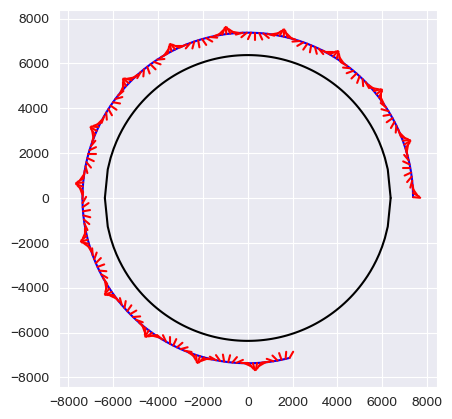

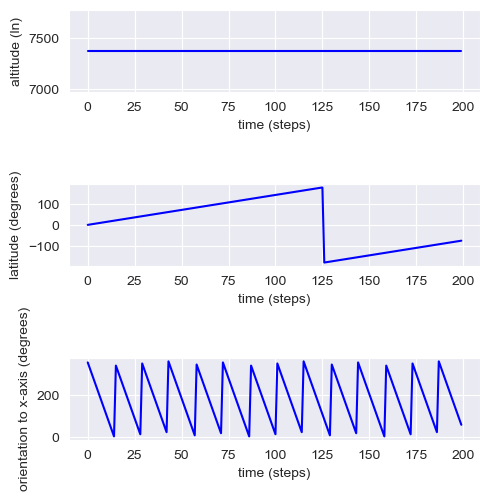

In [5]:
test_env.render(sample_traj_rate=5)

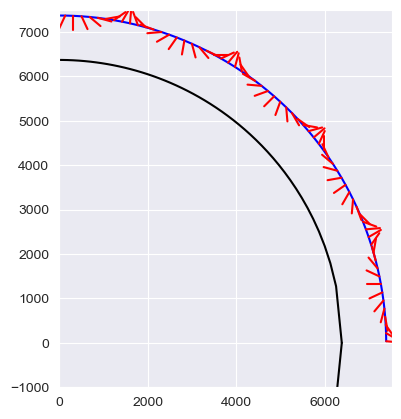

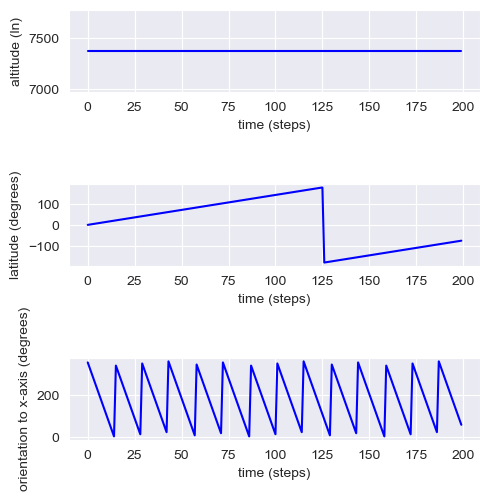

In [318]:
test_env.render(sample_traj_rate=5, xlim=[0, 7500], ylim=[-1000,7500])

In [43]:
obs = test_env.reset()

episode_R = 0.0 # episode initialization of reward
cutoff_s = 600.0 # main engine cut off time in seconds
MAX_TIME = 100*cutoff_s # setting the max time in seconds for the episode

# for use in this example policy
a = 2 # initial action -- thrust mode
thrust_tangent_s = 400.0

n = 0 # steps counter
done = False
checkpt_s = 0.0

traj_s = []
traj_a = []

while True:
    # policy - (Rotate Right 1 tick, Rotate Left 1 tick, Fire Booster Full Thrust, Do Nothing)
    # a = [0,1,2,3]
    
    traj_s.append(obs)
    
    # Test if we have main engine cut off (MECO)
    if test_env.elapsed_time_s > cutoff_s: # Cut off thrusting at cutoff_s seconds
        a = 4
    elif test_env.elapsed_time_s > thrust_tangent_s: # go up for awhile
        #turn tangential then thrust
        tan_angle = np.arctan2(np.cos(test_env.theta),-np.sin(test_env.theta))
        angle_dif = (test_env.orientation_angle-tan_angle)*180/np.pi
        if np.abs(angle_dif) > 1.0:
            if angle_dif < 0.0:
                a = 1
            else:
                a = 0
        else:
            a = 3
            
    traj_a.append(a)
    # apply control from policy
    n += 1
    obs, reward, done, info = test_env.step(a)
    
    # compute current episodic reward
    episode_R += reward
    
    # test if episode done
    if done:
        print('Final sim time -- ', test_env.elapsed_time_s, ' s')
        print('final state s = ', obs)
        print('episode reward: ', episode_R)
        print('n : ', n)
        print((test_env.elapsed_time > test_env.max_time))
        break

Final sim time --  849.0  s
final state s =  [1.74281574e+04 5.20949045e+02 1.37405403e+00 1.23707961e-02]
episode reward:  382.773168681344
n :  849
False


In [44]:
info

{'r violation 17428.157409556236, 17427.5'}

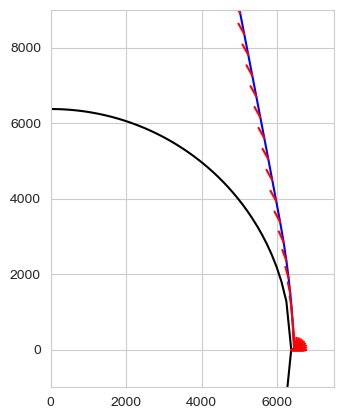

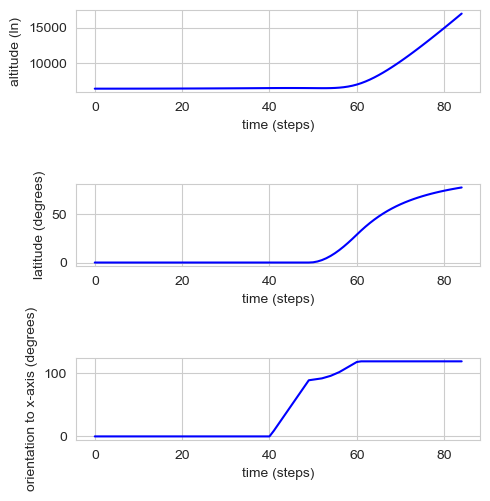

In [47]:
sns.set_style('whitegrid')
test_env.render(sample_traj_rate=2, xlim=[0, 7500], ylim=[-1000,9000])

## Vanilla Policy Gradient Method

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size, out_size):
        super(PGN,self).__init__()
        
        self.logit = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_size)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return self.logit(x), self.values(x)
    
policy_net = PGN(4,5).to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

policy_net.apply(init_weights)

using device:  cpu


PGN(
  (logit): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [29]:
state = test_env.reset()

# Pre-training if desired
ridx = np.random.choice(range(len(traj_s)),size = len(traj_s))

traj_s_np = np.vstack([np.array(traj_s)[ridx], state])
traj_s_np[:,0] = traj_s_np[:,0]/test_env.planet_R_ln

states_v = torch.FloatTensor(traj_s_np)

traj_a_np = np.hstack([np.array(traj_a)[ridx], 2])
actions_v = torch.LongTensor(traj_a_np)
#actions_v = torch.eye(4)[traj_a]

In [30]:
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [31]:
for e in range(7000):
    logits_v, values_v = policy_net(states_v)
    probs_v = F.softmax(logits_v, dim=1)
    
    loss_v = F.cross_entropy(probs_v,actions_v)
    loss_v += (values_v**2).mean()
    
    optimizer.zero_grad()
    loss_v.backward()
    optimizer.step()
    
    if e % 1000 == 0:
        print(loss_v.item())

817.9390869140625
1.2760322093963623
1.2636420726776123
1.2619719505310059
1.2611875534057617
1.2622212171554565
1.2603528499603271


In [33]:
state = test_env.reset()
episode_R = 0.0

while True:
    state[0] = state[0]/test_env.planet_R_ln
    state_v = torch.FloatTensor([state])
    logits_v = policy_net(state_v)[0]
    probs = F.softmax(logits_v, dim=1)
    probs = probs.data.cpu().numpy()[0]
    a = np.random.choice(range(len(probs)), p = probs)
    #a = np.argmax(probs)
    state, reward, is_done, info = test_env.step(a)
    
    episode_R += reward
    if is_done:
        break

print('episode R: ', episode_R)
print(info)

episode R:  -395.0819222977702
{'r violation 17435.85977700356, 17427.5'}


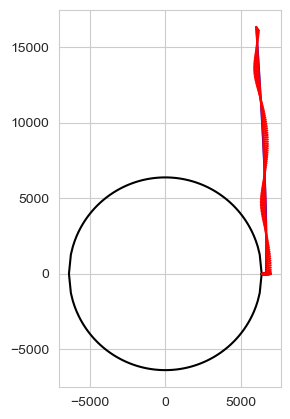

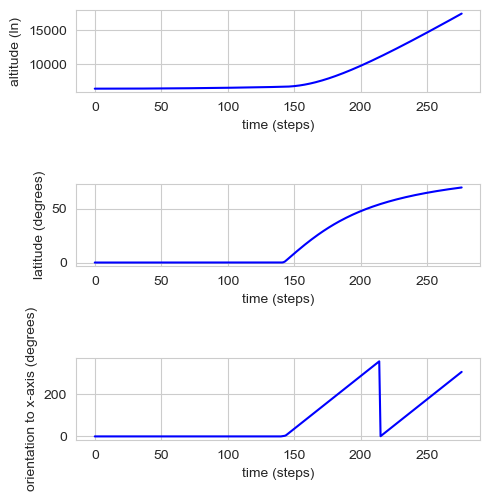

In [34]:
sns.set_style('whitegrid')
test_env.render()

In [35]:
def compute_discounted_rewards(epiode_rewards):
    batch_R = []
    R = 0.0
    for r in reversed(episode_rewards):
        R = r + GAMMA*R
        batch_R.append(R)
    
    q = list(reversed(batch_R))
    return q

In [36]:
# make sure the initial probabilities are even
s = env.reset()
s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
logits_v, _ = policy_net(s_v/env.planet_R_ln)
probs_v = F.softmax(logits_v, dim=1)

probs_v

tensor([[2.7553e-06, 2.7309e-04, 9.9972e-01, 5.1018e-06, 1.6078e-06]],
       grad_fn=<SoftmaxBackward>)

In [37]:
sample_states, sample_actions, sample_Rs = [],[],[]
episode_rewards = []

total_rewards = collections.deque(maxlen=100)

n_episodes = 0
done_episodes = 0
s = env.reset()

GAMMA = 0.99
LEARNING_RATE = 0.0001
SAMPLE_SIZE = 16
BATCH_SIZE = 64
ENTROPY_BETA = 0.1
CLIP_GRAD = 0.1

optimizer = optim.Adam(policy_net.parameters(), LEARNING_RATE)

while True:
    ## MAKE THE SAMPLES UNDER THE CURRENT POLICY
    s[0] = s[0]/env.planet_R_ln
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    logits_v, _ = policy_net(s_v)
    probs_v = F.softmax(logits_v, dim=1)
    probs = probs_v.data.cpu().numpy()
    a = np.random.choice(range(len(probs[0])), p=probs[0])
    s_prime, r, done,_ = env.step(a)
    episode_rewards.append(r)
    
    sample_states.append(s)
    sample_actions.append(a)
    
    if done:
        discounted_rewards = compute_discounted_rewards(episode_rewards)
        sample_Rs.extend(discounted_rewards)
        
        total_reward = np.sum(episode_rewards)
        total_rewards.append(total_reward)
        
        n_episodes += 1
        done_episodes += 1
        
        s = env.reset()
        episode_rewards.clear()
        
        
        ## PRINT THE STATUS EVERY 100 EPISODES
        if not (n_episodes == 0) and (n_episodes % 1000 == 0):
            ## COMPUTE MEAN REWARDS OVER THE CURRENT SAMPLE
            mean_rewards = np.mean(total_rewards)
        
            print('%d: mean reward: %.3f'%(n_episodes,mean_rewards))
            '''
            print(total_rewards)
            print('n_episodes: ', n_episodes)
            print('done_episodes: ',done_episodes)
            print('done: ', done)
            print('a: ', a)
            print('break')
            break
            '''
            ## CHECK THE SOLVED CONDITION
            if (mean_rewards > 1000) and (np.std(total_rewards) < 10):
                print('Solved.')
                break
    else:
        s = s_prime
    
    ## KEEP MAKING EM TILL YOU GOT THE SAMPLE SIZE
    if done_episodes < SAMPLE_SIZE:
        continue
    
    '''
    print("Tuning...", n_episodes, done_episodes)
    print('sample_states.shape', len(sample_states))
    print('sample_actions.shape', len(sample_actions))
    print('sample_Rs.shape', len(sample_Rs))
    print('batches: ', int(np.ceil(len(sample_states)/BATCH_SIZE)))
    '''
    
    # segment the data into batches
    sample_states_batches = np.array_split(sample_states, int(np.ceil(len(sample_states)/BATCH_SIZE) ))
    sample_actions_batches = np.array_split(sample_actions, int(np.ceil(len(sample_actions)/BATCH_SIZE) ))
    sample_Rs_batches = np.array_split(sample_Rs, int(np.ceil(len(sample_Rs)/BATCH_SIZE) ))
    
    bidx = 0
    for sample_state_batch, sample_actions_batch, sample_Rs_batch in zip(sample_states_batches,sample_actions_batches,sample_Rs_batches):
        #print('\t training batch: ', bidx)
        bidx += 1
        optimizer.zero_grad()
        sample_states_v = torch.FloatTensor(sample_states).to(device)
        sample_actions_v = torch.LongTensor(sample_actions).to(device)
        sample_Rs_v = torch.FloatTensor(sample_Rs).to(device)
    
        logits_v, values_v = policy_net(sample_states_v)
        log_prob_v = F.log_softmax(logits_v, dim=1)
    
        # Value iteration
        loss_value_v = F.mse_loss(values_v.squeeze(), sample_Rs_v)
    
        # -sum_s sum_a pi(a|s) log pi(a|s) > 0
        entropy_v = -ENTROPY_BETA*(F.softmax(logits_v, dim=1)*log_prob_v).sum(dim=1)
        entropy_v = entropy_v.mean()
    
        # Policy Loss
        loss_v = (sample_Rs_v-values_v.detach())*log_prob_v[range(len(log_prob_v)), sample_actions_v]
    
        # total loss, minimize this
        loss_v = -loss_v.mean() - entropy_v + loss_value_v
    
        loss_v.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    done_episodes = 0
    sample_states.clear()
    sample_actions.clear()
    sample_Rs.clear()

KeyboardInterrupt: 

-1125.3740984363012 2947.9224533381753


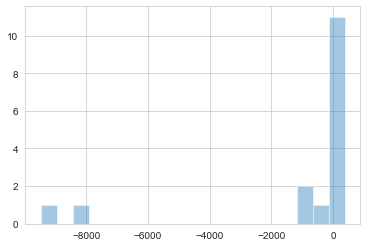

In [38]:
print(np.mean(total_rewards), np.std(total_rewards))
sns.distplot(total_rewards,kde=False);

Episode Reward:  -1504.7076574487717
{'r violation 17439.27288523956, 17427.5'}


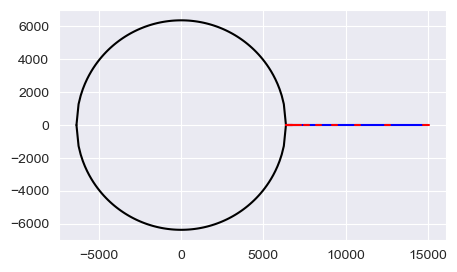

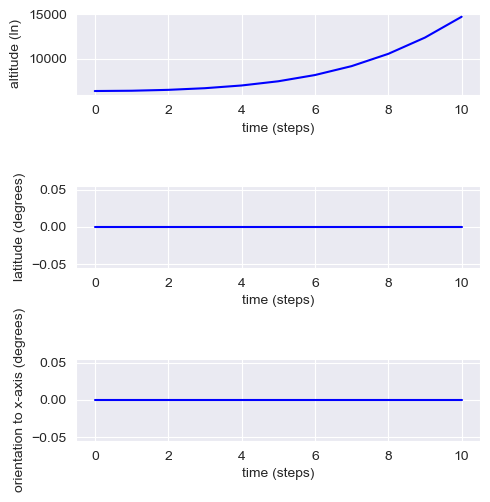

In [40]:
s = test_env.reset()

episode_reward = 0.0

program_cmd_history = []

done = False
while not done:
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    logits_v, _ = policy_net(s_v)
    probs_v = F.softmax(logits_v, dim=1)
    probs = probs_v.data.cpu().numpy()
    a = np.random.choice(range(len(probs[0])), p=probs[0])
    program_cmd_history.append(a)    
    s, r, done,info = test_env.step(a)
    episode_reward +=r

print('Episode Reward: ', episode_reward)
print(info)
sns.set_style('darkgrid')
test_env.render(sample_traj_rate=50)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


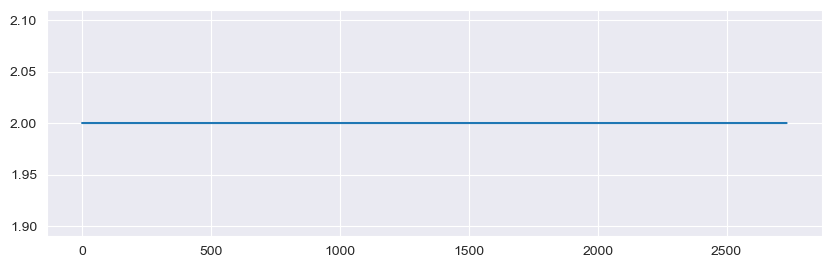

In [41]:
plt.figure(figsize=(10,3), dpi=100)
print(program_cmd_history[:10])
plt.plot(program_cmd_history);